# Fall 2024 Data Science Track: Week 5 - Unsupervised Learning

## Packages, Packages, Packages!

Import *all* the things here! You need: `matplotlib`, `networkx`, `numpy`, and `pandas`―and also `ast.literal_eval` to correctly deserialize two columns in the `rules.tsv.xz` file.

If you got more stuff you want to use, add them here too. 🙂

In [1]:
# Don’t worry about this. This is needed to interpret the Python code that is embedded in the data set. You only need it literally in the very next code cell and nowhere else. 
from ast import literal_eval

# The rest is just the stuff from the lecture.
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

# Instacart Association Rules

## Introduction

With the packages out of the way, now you will be working with the Instacart association rules data set, mined from the [Instacart Market Basket Analysis data set](https://www.kaggle.com/c/instacart-market-basket-analysis/data) on Kaggle. [The script](https://github.com/LiKenun/shopping-assistant/blob/main/api/preprocess_instacart_market_basket_analysis_data.py) that does it and the instructions to run it can be found in my [Shopping Assistant Project](https://github.com/LiKenun/shopping-assistant) repository.

## Load the Data

This code has already been pre-written, simply because there are a few quirks which require converters to ensure the correct deserialization of some columns.

In [2]:
rules_data_path = 'data/rules.tsv.xz'                       # You do not need to decompress this yourself. Pandas understands how to read compressed data.

df_rules = pd.read_csv(rules_data_path,
                       sep='\t',
                       quoting=3,                           # This disables interpretation of quotes by Pandas itself, because both single and double quotes will be resolved by literal_eval.
                       converters={
                           'consequent_item': literal_eval,
                           'antecedent_items': literal_eval # This reads something like ["Grandma's 8\" Chip Cookies", '6" Apple Pie'] into a list, so you will get a column where each individual cell is a list.
                       },
                       low_memory=True)                     # For Chris

<unknown>:1: SyntaxWarning: invalid escape sequence '\G'


But just *how* many rules were just loaded‽

In [3]:
# Show the list of column names and the number of rules.
df_rules.info()
df_rules.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 6 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   consequent_item    1048575 non-null  object
 1   transaction_count  1048575 non-null  int64 
 2   item_set_count     1048575 non-null  int64 
 3   antecedent_count   1048575 non-null  int64 
 4   consequent_count   1048575 non-null  int64 
 5   antecedent_items   1048575 non-null  object
dtypes: int64(4), object(2)
memory usage: 48.0+ MB


,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items
0,Total 2% with Raspberry Pomegranate Lowfat Gre...,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2..."
1,Total 2% Lowfat Greek Strained Yogurt With Blu...,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr..."
2,Total 0% with Honey Nonfat Greek Strained Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2..."
3,Total 0% Raspberry Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2..."
4,Pineapple Yogurt 2%,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr..."


## Metrics

Compute the support, confidence, and lift of each rule.

* The rule’s *support* tells you how frequently the set of items appears in the dataset. It’s important to prune infrequent sets from further consideration.
    * The simple definition: $$P(A \cap B)$$
    * `= item_set_count / transaction_count`
* The rule’s *confidence* tells you how often a the rule is true. Divide the support for the set of items by the support for just the antecedents. Rules which are not true very often are also pruned.
    * The simple definition: $$\frac{P(A \cap B)}{P(A)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count)`
    * `= item_set_count / antecedent_count`
* The rule’s *lift* tells you how much more likely the consequent is, given the antecedents, compared to its baseline probability. Divide the support for the set of items by both the support of the antecedents and consequent. Equivalently, divide the confidence by the support of the consequent.
    * The simple definition: $$\frac{P(A \cap B)}{P(A) \cdot P(B)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count * (consequent_count / transaction_count))`
    * `= item_set_count / antecedent_count / (consequent_count / transaction_count)`
    * `= item_set_count * transaction_count / (antecedent_count * consequent_count)`

In [4]:
# Add new columns support, confidence, and lift to df_rules. And show the first 50 rules.

transaction_count = df_rules['transaction_count'].iloc[0]
df_rules['support'] = df_rules['item_set_count'] / transaction_count
df_rules['confidence'] = df_rules['item_set_count'] / df_rules['antecedent_count']
df_rules['lift'] = df_rules['item_set_count'] * transaction_count / (df_rules['antecedent_count'] * df_rules['consequent_count'])

df_rules.head(50)


,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
0,Total 2% with Raspberry Pomegranate Lowfat Gre...,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.000030,0.821138,21465.598514
1,Total 2% Lowfat Greek Strained Yogurt With Blu...,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr...",0.000030,0.789062,21465.598514
2,Total 0% with Honey Nonfat Greek Strained Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.000030,0.821138,21465.598514
3,Total 0% Raspberry Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.000030,0.821138,21465.598514
4,Pineapple Yogurt 2%,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr...",0.000030,0.789062,21465.598514
5,Fat Free Strawberry Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.000030,0.821138,21465.598514
6,Fat Free Blueberry Yogurt,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr...",0.000030,0.789062,21465.598514
7,Total 2% with Raspberry Pomegranate Lowfat Gre...,3346083,101,147,117,"[Blackberry Yogurt, Fat Free Strawberry Yogurt...",0.000030,0.687075,19649.653061
8,Total 2% Lowfat Greek Strained Yogurt With Blu...,3346083,101,147,117,"[Blackberry Yogurt, Fat Free Strawberry Yogurt...",0.000030,0.687075,19649.653061
9,Total 2% Greek Strained Yogurt with Cherry 5.3 oz,3346083,101,117,147,"[Pineapple Yogurt 2%, Total 0% Raspberry Yogur...",0.000030,0.863248,19649.653061


The yogurts have got some insane lift (*over 9,000*). Why do you think that might be?

*(Write your answer here.)*
Yogurts might have high lift because people might be purchasing multiple flavors at the same time.

In [5]:
# Query the rule set if you have to to find out more.
df_rules.head()

,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
0,Total 2% with Raspberry Pomegranate Lowfat Gre...,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.00003,0.821138,21465.598514
1,Total 2% Lowfat Greek Strained Yogurt With Blu...,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr...",0.00003,0.789062,21465.598514
2,Total 0% with Honey Nonfat Greek Strained Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.00003,0.821138,21465.598514
3,Total 0% Raspberry Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.00003,0.821138,21465.598514
4,Pineapple Yogurt 2%,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr...",0.00003,0.789062,21465.598514


## Network Visualization for Consequents with Single Antecedents

Let’s now visualize a small subset of 1,000,000+ rules. First, filter the rule set for the following to whittle it down to something more manageable:

1. The rule must have exactly `1` antecedent item. (There should be 38,684 such rules.)
2. The lift must be between `5` and `20`. (There should be 1,596 such rules, including the prior criterion.)
3. Either the antecedent or consequent of the rule must contain `'Hummus'`, but not both. (This should get you down to 26 rules.)
    * Convert the antecedents `list`-typed column to a `str`-typed column (`antecedent_item`) since there will only be a single antecedent in the subset.
    * Replace any item containing `'Hummus'` to just `'Hummus'`. This will make the visualization more readable later.

Hint: your code may run more efficiently if you re-order certain processing steps.

Assign the subset to `df_rules_subset`.

In [6]:
# Define df_rules_subset.


df_rules_subset = df_rules[
    (df_rules['antecedent_items'].apply(len) == 1) &
    (df_rules['lift'].between(5, 20)) &
    (df_rules['antecedent_items'].apply(lambda x: 'Hummus' in x) ^ df_rules['consequent_item'].apply(lambda x: 'Hummus' in x))
].copy()

df_rules_subset['antecedent_item'] = df_rules_subset['antecedent_items'].apply(lambda x: 'Hummus' if 'Hummus' in x else x[0])
df_rules_subset['consequent_item'] = df_rules_subset['consequent_item'].apply(lambda x: 'Hummus' if 'Hummus' in x else x)


Build a network `graph_rules_subset` from the association rules subset.

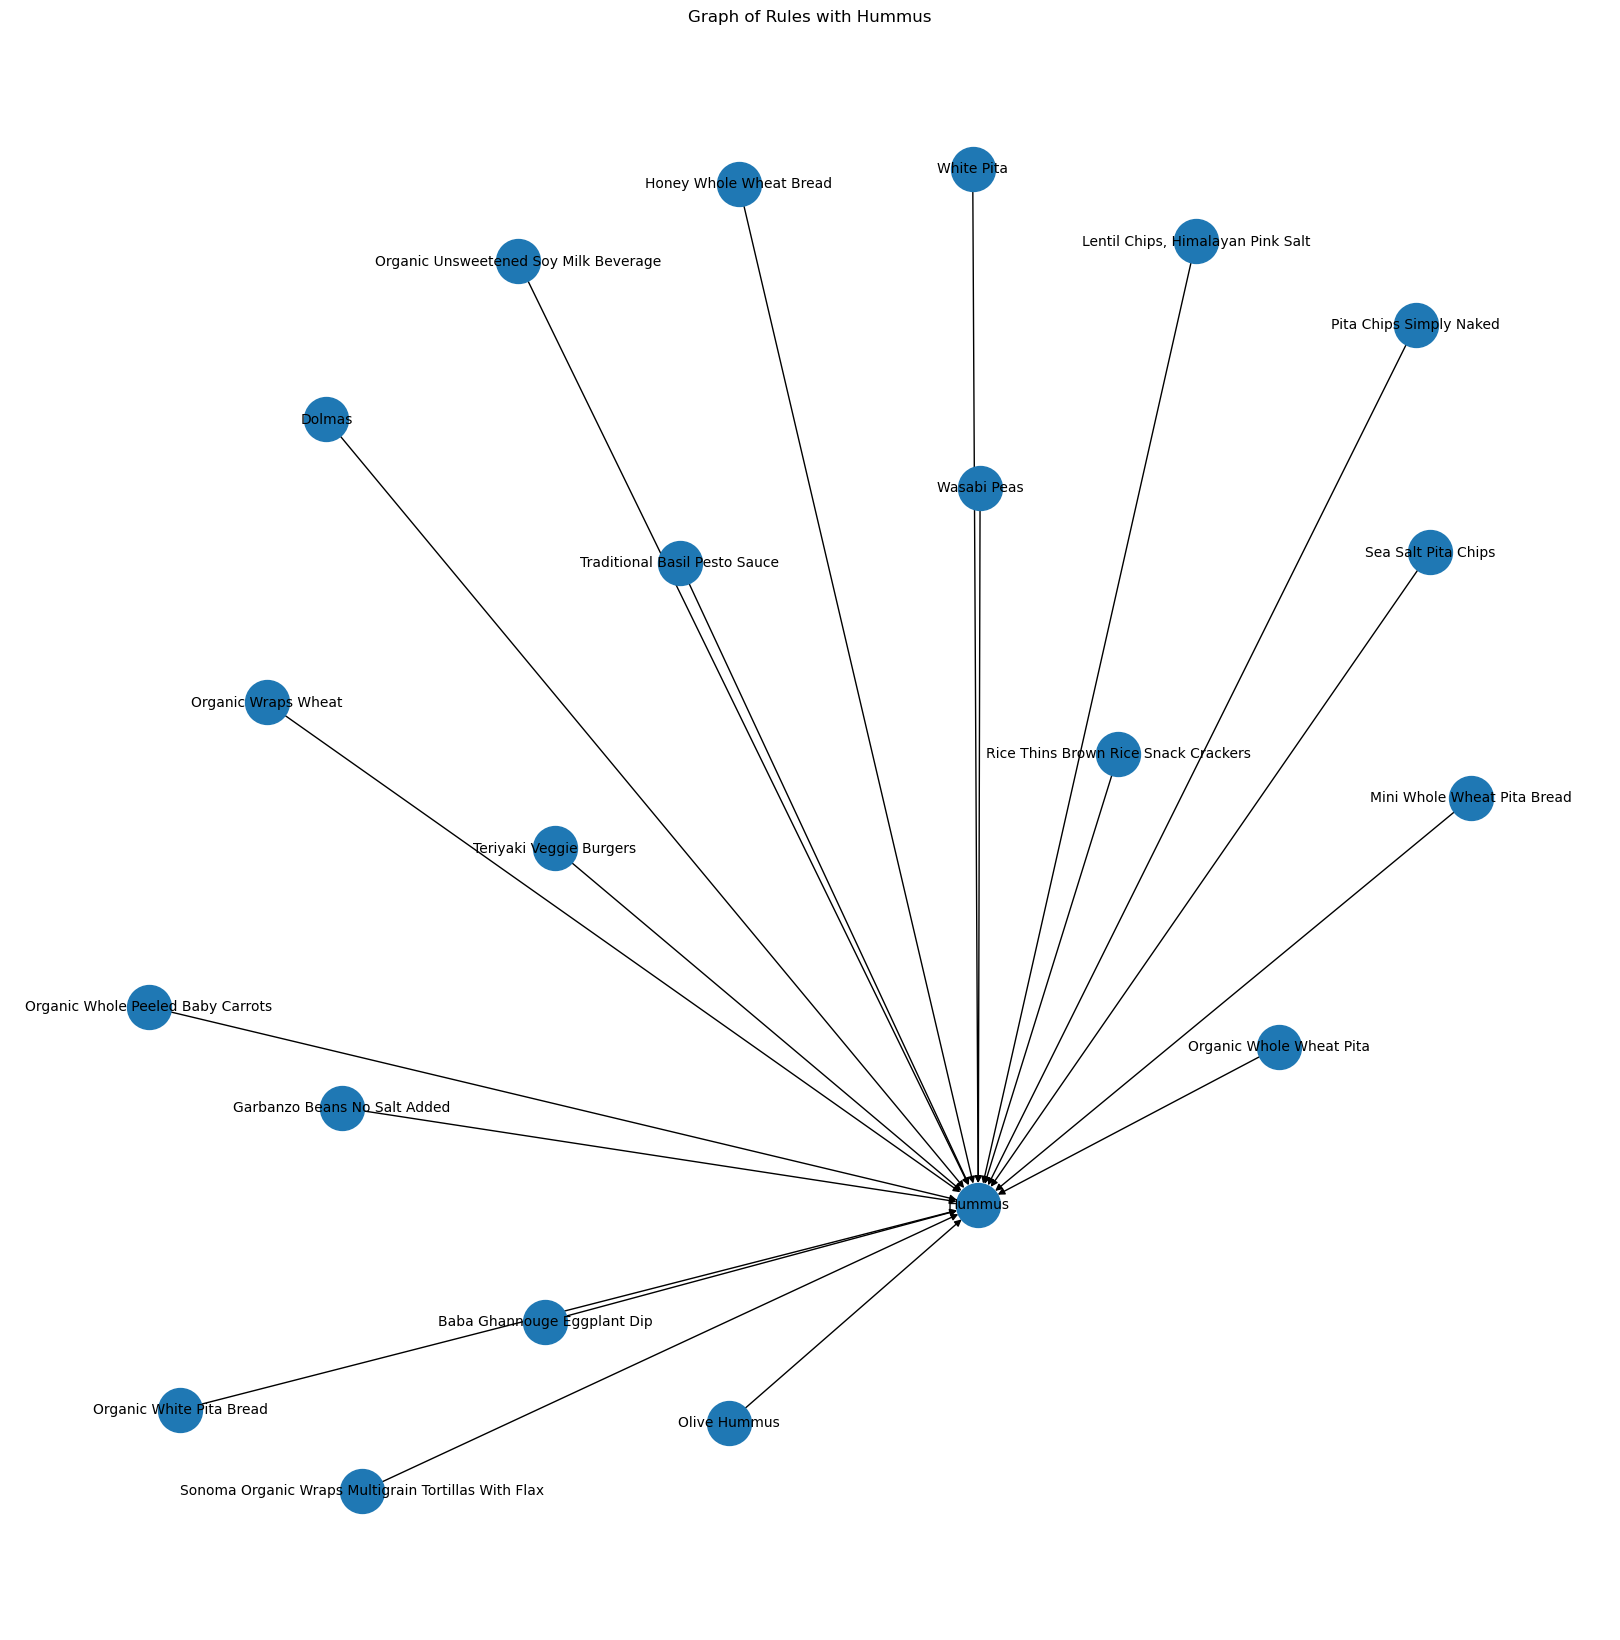

In [10]:
# Define graph_rules_subset, add the graph’s edges, and plot it. You may need a large figure size, smaller node size, and smaller font size.

graph_rules_subset = nx.MultiDiGraph()

# Add edges, handling lists in antecedent_items
for index, row in df_rules_subset.iterrows():
    antecedents = row['antecedent_items']
    consequent = row['consequent_item']
    if isinstance(antecedents, list):  # Check if it's a list
        for antecedent in antecedents:
            graph_rules_subset.add_edge(antecedent, consequent)
    else:
        graph_rules_subset.add_edge(antecedents, consequent)

# Plot the graph
plt.figure(figsize=(16, 16))  # Adjust the figure size as needed
pos = nx.spring_layout(graph_rules_subset, k=0.5)  # Increase k to space nodes further apart

# Draw nodes and edges
nx.draw(graph_rules_subset, pos, with_labels=True, node_size=1000, font_size=10)

# Show plot
plt.title("Graph of Rules with Hummus")
plt.show()

What can you tell about people who buy hummus?

*(Write your answer here.)*

## Make a Prediction

Given that the basket of items contains the following items, use the full set of association rules to predict the next 20 most likely items (consequents) that the person will add to the basket in descending order of lift:

* `'Orange Bell Pepper'`
* `'Organic Red Bell Pepper'`

Hint: a single item in the basket may be a better predictor of some consequents than both items considered together. You must consider both or either, but not neither.

In [11]:
# Define the basket
basket = {'Orange Bell Pepper', 'Organic Red Bell Pepper'}

# Filter the DataFrame based on the conditions
df_filtered = df_rules[
    (df_rules['antecedent_items'].apply(lambda x: isinstance(x, list) and any(item in basket for item in x))) | 
    (df_rules['antecedent_items'].apply(lambda x: isinstance(x, str) and x in basket))
]

# Sort by 'lift' and select the top 20
df_top_rules = df_filtered.sort_values('lift', ascending=False).head(20)

# Display the resulting DataFrame
print(df_top_rules)


                                          consequent_item  transaction_count  \
342462      Icelandic Style Skyr Blueberry Non-fat Yogurt            3346083   
345882      Icelandic Style Skyr Blueberry Non-fat Yogurt            3346083   
346832           Nonfat Icelandic Style Strawberry Yogurt            3346083   
346901                           Non Fat Raspberry Yogurt            3346083   
349532      Icelandic Style Skyr Blueberry Non-fat Yogurt            3346083   
350852      Icelandic Style Skyr Blueberry Non-fat Yogurt            3346083   
350991                           Non Fat Raspberry Yogurt            3346083   
351360      Icelandic Style Skyr Blueberry Non-fat Yogurt            3346083   
351433           Nonfat Icelandic Style Strawberry Yogurt            3346083   
351881      Icelandic Style Skyr Blueberry Non-fat Yogurt            3346083   
352283                         Vanilla Skyr Nonfat Yogurt            3346083   
352884                        Organic Fr

## Bonus: Other Interesting Findings

Find and share something else interesting about these association rules. It can be a graph, table, or some other format that illustrates your point.